# Different Expression Analysis

An important task of bulk rna-seq analysis is the different expression , which we can perform with omicverse. For different expression analysis, ov change the `gene_id` to `gene_name` of matrix first. When our dataset existed the batch effect, we can use the SizeFactors of DEseq2 to normalize it, and use `t-test` of `wilcoxon` to calculate the p-value of genes. Here we demonstrate this pipeline with a matrix from `featureCounts`. The same pipeline would generally be used to analyze any collection of RNA-seq tasks. 

Colab_Reproducibility：https://colab.research.google.com/drive/1q5lDfJepbtvNtc1TKz-h4wGUifTZ3i0_?usp=sharing

In [1]:
import omicverse as ov
import scanpy as sc
import matplotlib.pyplot as plt

ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 04日 星期一 18:20:19 CST


## Geneset Download

When we need to convert a gene id, we need to prepare a mapping pair file. Here we have pre-processed 6 genome gtf files and generated mapping pairs including `T2T-CHM13`, `GRCh38`, `GRCh37`, `GRCm39`, `danRer7`, and `danRer11`. If you need to convert other id_mapping, you can generate your own mapping using gtf Place the files in the `genesets` directory.

In [2]:
ov.utils.download_geneid_annotation_pair()

......Geneid Annotation Pair download start: pair_GRCm39
......Loading dataset from genesets/pair_GRCm39.tsv
......Geneid Annotation Pair download start: pair_T2TCHM13
......Loading dataset from genesets/pair_T2TCHM13.tsv
......Geneid Annotation Pair download start: pair_GRCh38
......Loading dataset from genesets/pair_GRCh38.tsv
......Geneid Annotation Pair download start: pair_GRCh37
......Loading dataset from genesets/pair_GRCh37.tsv
......Geneid Annotation Pair download start: pair_danRer11
......Loading dataset from genesets/pair_danRer11.tsv
......Geneid Annotation Pair download start: pair_danRer7
......Loading dataset from genesets/pair_danRer7.tsv
......Geneid Annotation Pair download finished!


Note that this dataset has not been processed in any way and is only exported by `featureCounts`, and Sequence alignment was performed from the genome file of CRCm39

sample data can be download from: https://raw.githubusercontent.com/Starlitnightly/omicverse/master/sample/counts.txt

In [3]:
data=ov.pd.read_csv('https://raw.githubusercontent.com/Starlitnightly/omicverse/master/sample/counts.txt',index_col=0,sep='\t',header=1)
#data=ov.read('data/counts.txt',index_col=0,header=1)
#replace the columns `.bam` to `` 
data.columns=[i.split('/')[-1].replace('.bam','') for i in data.columns]
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Geneid,,,,,,,,,,,,
ENSMUSG00000102628,0,0,0,0,5,0,0,0,0,0,0,9
ENSMUSG00000100595,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000097426,5,0,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,0,0,0


## ID mapping

We performed the gene_id mapping by the mapping pair file `GRCm39` downloaded before.

In [4]:
data=ov.bulk.Matrix_ID_mapping(data,'genesets/pair_GRCm39.tsv')
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Gm44973,0,0,0,0,0,0,0,0,0,0,0,0
Cmtm2a,0,0,0,0,0,0,1,1,2,2,0,0
Gm8367,0,0,0,0,0,0,0,0,0,0,0,0
Gm29637,0,0,0,0,0,0,0,0,0,0,0,0
Gm47251,3,20,0,14,24,17,14,24,22,16,29,5


## Different expression analysis with ov

We can do differential expression analysis very simply by ov, simply by providing an expression matrix. To run DEG, we simply need to:

- Read the raw count by featureCount or any other qualify methods.
- Create an ov DEseq object.

In [5]:
dds=ov.bulk.pyDEG(data)

We notes that the gene_name mapping before exist some duplicates, we will process the duplicate indexes to retain only the highest expressed genes

In [6]:
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


We also need to remove the batch effect of the expression matrix, `estimateSizeFactors` of DEseq2 to be used to normalize our matrix

In [7]:
dds.normalize()
print('... estimateSizeFactors and normalize success')

... estimateSizeFactors and normalize success


Now we can calculate the different expression gene from matrix, we need to input the treatment and control groups

### ttest

In [8]:
treatment_groups=['4-3','4-4']
control_groups=['1--1','1--2']
result_ttest=dds.deg_analysis(treatment_groups,control_groups,method='ttest')
result_ttest.sort_values('qvalue').head()

⚙️ You are using ttest method for differential expression analysis.
⏰ Start to calculate qvalue...
✅ Differential expression analysis completed.


,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
Uqcrh,0.000004,0.000008,1.340801,2847.940209,2485.969738,11.279593,0.423095,0.423095,0.134080,5.384073,5.092813,sig
Glo1-ps,0.000016,0.000031,0.538892,1718.015690,1321.865457,10.368360,-0.891933,0.891933,0.053889,4.806087,4.514843,sig
Tdrd7,0.000017,0.000033,0.820013,570.589428,519.218764,9.020199,-0.286282,0.286282,0.082001,4.771736,4.480507,sig
Kmt2a,0.000027,0.000053,1.203164,1337.284342,1224.358694,10.257811,0.266833,0.266833,0.120316,4.568148,4.276934,sig
Gm8444,0.000028,0.000055,5.216317,0.996510,0.498255,-1.005044,2.383032,2.383032,0.521632,4.549549,4.259487,sig


### (optional) edgeR with python

This module is a partial port in Python of the R Bioconductor [edgeR package](https://bioconductor.org/packages/release/bioc/html/edgeR.html).

In [9]:
result_edgepy=dds.deg_analysis(treatment_groups,control_groups,method='edgepy')
result_edgepy.sort_values('qvalue').head()

⚙️ You are using edgepy method for differential expression analysis.
⏰ Start to create DGEList...


⏰ Start to calculate qvalue...
✅ Differential expression analysis completed.


,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
gene_id,,,,,,,,,,,,
Krtap9-5,3.947451e-47,2.151519e-42,0.000473,1547.679064,774.087336,9.596353,-11.046285,11.046285,1.104629,46.403683,41.667255,sig
Krtap31-2,4.617746e-37,1.258428e-32,0.005277,2119.816858,1065.383939,10.057158,-7.566086,7.566086,0.756609,36.335570,31.900172,sig
Krtap19-4,1.366794e-34,2.483192e-30,0.007052,1801.548456,907.009031,9.824973,-7.147779,7.147779,0.714778,33.864297,29.604990,sig
Gm4553,5.538862e-34,7.547253e-30,0.007581,1747.371062,880.191957,9.781674,-7.043332,7.043332,0.704333,33.256579,29.122211,sig
Krtap19-1,3.307845e-30,3.605815e-26,0.012397,1824.734049,923.560556,9.851063,-6.333913,6.333913,0.633391,29.480455,25.442997,sig


## (optional) limma

This module is a partial port in Python of the R Bioconductor [limma package](https://bioconductor.org/packages/release/bioc/html/limma.html).

In [10]:
result_limma=dds.deg_analysis(treatment_groups,control_groups,method='limma')
result_limma.sort_values('qvalue').head()

[WARNING] More than half of residual variances are exactly zero: eBayes unreliable


⚙️ You are using limma method for differential expression analysis.
⏰ Start to create DGEList...
⏰ Start to adjust pvalue...
✅ Differential expression analysis completed.


,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,sig,-log(pvalue),-log(qvalue),F,t
gene_id,,,,,,,,,,,,,,
Gm38036,0.000009,0.007894,9.432635,1.99302,0.996510,-0.005044,3.237661,3.237661,0.323766,sig,5.023982,2.102706,37058.986321,192.507107
Glo1-ps,0.000005,0.007894,0.538892,1718.01569,1321.865457,10.368360,-0.891933,0.891933,0.089193,sig,5.340863,2.102706,71318.175384,-267.054630
Gm43313,0.000011,0.007894,5.216317,0.99651,0.498255,-1.005044,2.383032,2.383032,0.238303,sig,4.941507,2.102706,31253.277503,176.785965
Gm20069,0.000009,0.007894,9.432635,1.99302,0.996510,-0.005044,3.237661,3.237661,0.323766,sig,5.023982,2.102706,37058.986321,192.507107
4930594C11Rik,0.000011,0.007894,5.216317,0.99651,0.498255,-1.005044,2.383032,2.383032,0.238303,sig,4.941507,2.102706,31253.277503,176.785965


One important thing is that we do not filter out low expression genes when processing DEGs, and in future versions I will consider building in the corresponding processing.

In [11]:
print(dds.result.shape)
dds.result=dds.result.loc[dds.result['log2(BaseMean)']>1]
print(dds.result.shape)

(54504, 14)
(21279, 14)


We also need to set the threshold of Foldchange, we prepare a method named `foldchange_set` to finish. This function automatically calculates the appropriate threshold based on the log2FC distribution, but you can also enter it manually.

In [12]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=6)

... Fold change threshold: 1.5700186501202582


## Visualize the DEG result and specific genes

To visualize the DEG result, we use `plot_volcano` to do it. This fuction can visualize the gene interested or high different expression genes. There are some parameters you need to input:

- title: The title of volcano
- figsize: The size of figure
- plot_genes: The genes you interested
- plot_genes_num: If you don't have interested genes, you can auto plot it.

🌋 Volcano Plot Analysis:
   Total genes: 21279
   ↗️  Upregulated genes: 11
   ↘️  Downregulated genes: 10
   ➡️  Non-significant genes: 21258
   🎯 Total significant genes: 21
   log2FC range: -11.05 to 8.36
   qvalue range: 7.89e-03 to 1.00e+00

⚙️  Current Function Parameters:
   Data columns: pval_name='qvalue', fc_name='log2FC'
   Thresholds: pval_threshold=0.05, fc_max=1.5700186501202582, fc_min=-1.5700186501202582
   Plot size: figsize=(4, 4)
   Gene labels: plot_genes_num=8, plot_genes_fontsize=12
   Custom genes: None (auto-select top genes)

💡 Parameter Optimization Suggestions:
   ▶ Wide fold change range detected:
     Current: fc_max=1.5700186501202582, fc_min=-1.5700186501202582
     Suggested: fc_max=2.0, fc_min=-1.7

   📋 Copy-paste ready function call:
   ov.pl.volcano(result, fc_max=2.0, fc_min=-1.7)
────────────────────────────────────────────────────────────
0 [0.09762701 0.43037873]
1 [0.20552675 0.08976637]
0 [-0.1526904   0.29178823]
1 [-0.12482558  0.783546  ]


<Axes: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

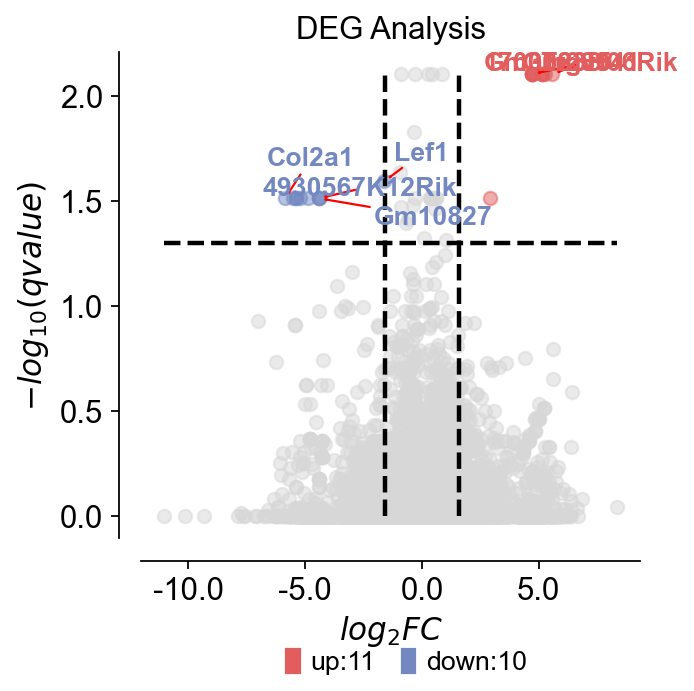

In [13]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

To visualize the specific genes, we only need to use the `dds.plot_boxplot` function to finish it.

(<Figure size 400x240 with 1 Axes>,
 <Axes: title={'center': 'Gene Expression'}>)

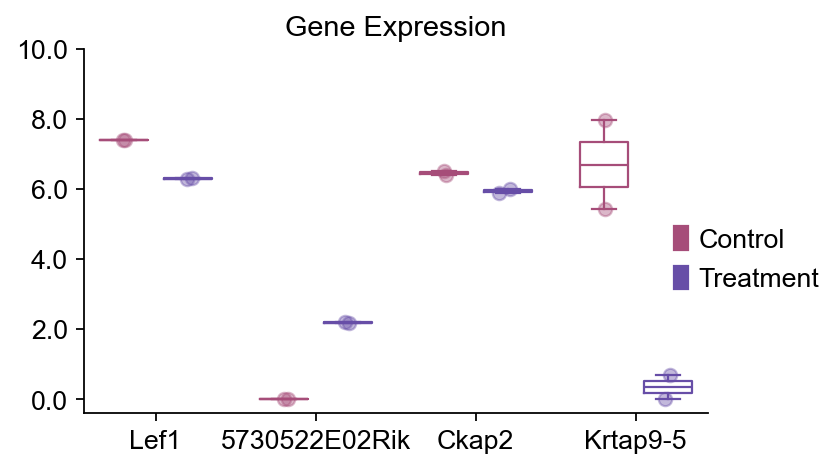

In [14]:
dds.plot_boxplot(genes=['Ckap2','Lef1','Krtap9-5','5730522E02Rik'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(5,3),fontsize=12,
                 legend_bbox=(1.2,0.55))

[Text(0, 5.800000000000001, '5.8'),
 Text(0, 6.000000000000001, '6.0'),
 Text(0, 6.200000000000001, '6.2'),
 Text(0, 6.4, '6.4'),
 Text(0, 6.6000000000000005, '6.6')]

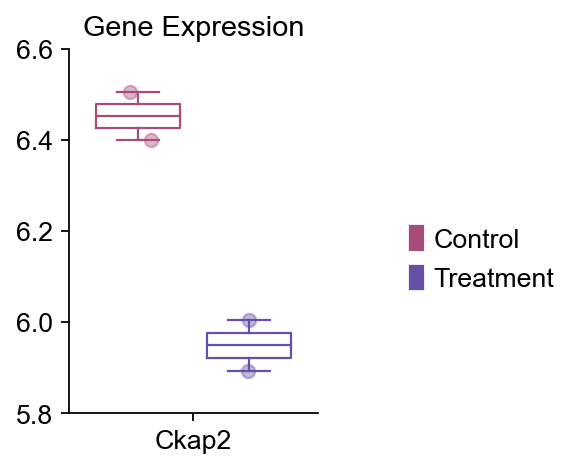

In [15]:
fig,ax=dds.plot_boxplot(genes=['Ckap2'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))
#convert the ytickbels
ax.set_yticklabels([round(float(i.get_text()),2) for i in ax.get_yticklabels()])

## Pathway enrichment analysis by ov

Here we use the `gseapy` package, which included the GSEA analysis and Enrichment. We have optimised the output of the package and given some better looking graph drawing functions

Similarly, we need to download the pathway/genesets first. Five genesets we prepare previously, you can use `ov.utils.download_pathway_database()` to download automatically. Besides, you can download the pathway you interested from enrichr: https://maayanlab.cloud/Enrichr/#libraries

In [16]:
ov.utils.download_pathway_database()

......Pathway Geneset download start: GO_Biological_Process_2021
......Loading dataset from genesets/GO_Biological_Process_2021.txt
......Pathway Geneset download start: GO_Cellular_Component_2021
......Loading dataset from genesets/GO_Cellular_Component_2021.txt
......Pathway Geneset download start: GO_Molecular_Function_2021
......Loading dataset from genesets/GO_Molecular_Function_2021.txt
......Pathway Geneset download start: WikiPathway_2021_Human
......Loading dataset from genesets/WikiPathway_2021_Human.txt
......Pathway Geneset download start: WikiPathways_2019_Mouse
......Loading dataset from genesets/WikiPathways_2019_Mouse.txt
......Pathway Geneset download start: Reactome_2022
......Loading dataset from genesets/Reactome_2022.txt
......Pathway Geneset download finished!
......Other Genesets can be dowload in `https://maayanlab.cloud/Enrichr/#libraries`


In [17]:
pathway_dict=ov.utils.geneset_prepare('genesets/WikiPathways_2019_Mouse.txt',organism='Mouse')

Note that the `pvalue_type` we set to `auto`, this is because when the genesets we enrichment if too small, use the `adjusted pvalue` we can't get the correct result. So you can set `adjust` or `raw` to get the significant geneset.

If you didn't have internet, please set `background` to all genes expressed in rna-seq,like:

```python
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                background=dds.result.index.tolist(),
                                organism='mouse')
```

In [18]:
deg_genes=dds.result.loc[dds.result['sig']!='normal'].index.tolist()
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')

To visualize the enrichment, we use `geneset_plot` to finish it

<Axes: title={'center': 'Wiki Pathway enrichment'}, xlabel='Fractions of genes'>

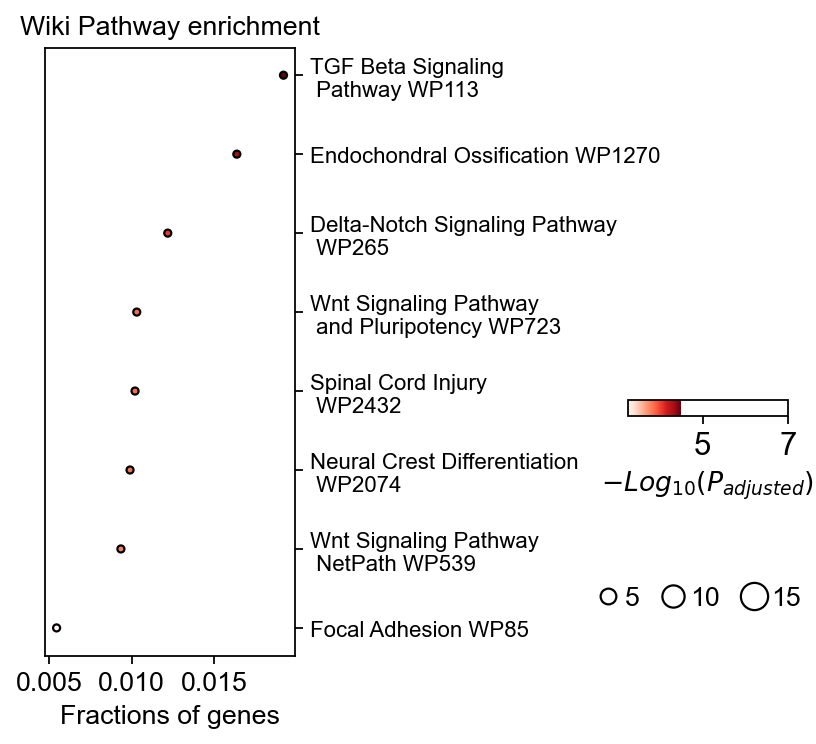

In [19]:
ov.bulk.geneset_plot(enr,figsize=(2,5),fig_title='Wiki Pathway enrichment',
                    cax_loc=[2, 0.45, 0.5, 0.02],
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=10,
                     custom_ticks=[5,7],text_knock=3,
                    cmap='Reds')

## Multi pathway enrichment

In addition to pathway enrichment for a single database, OmicVerse supports enriching and visualizing multiple pathways at the same time, which is implemented using [`pyComplexHeatmap`](https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/gene_enrichment_analysis.html), and Citetation is welcome!

In [20]:
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Biological_Process_2023.txt',organism='Mouse')
enr_go_bp=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Molecular_Function_2023.txt',organism='Mouse')
enr_go_mf=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Cellular_Component_2023.txt',organism='Mouse')
enr_go_cc=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 426.8058990367811
Plotting legends..
Estimated legend width: 11.860366666666666 mm


<Axes: ylabel='$−Log_{10}(P_{adjusted})$'>

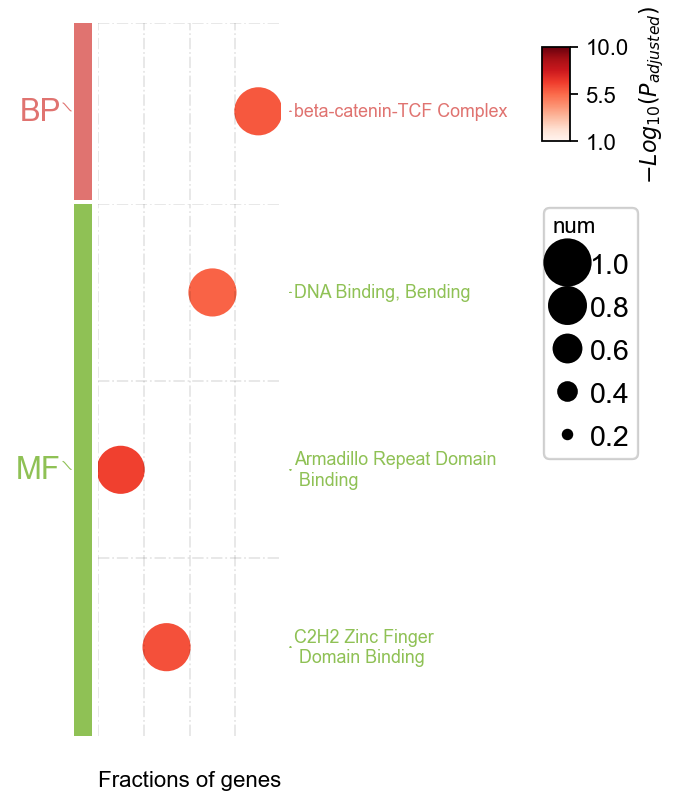

In [21]:
enr_dict={'BP':enr_go_bp,
         'MF':enr_go_mf,
         'CC':enr_go_cc}
colors_dict={
    'BP':ov.pl.red_color[1],
    'MF':ov.pl.green_color[1],
    'CC':ov.pl.blue_color[1],
}
ov.bulk.geneset_plot_multi(enr_dict,colors_dict,num=3,
                   figsize=(2,5),
                   text_knock=3,fontsize=8,
                    cmap='Reds'
                  )